In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
import tensorflow as tf

In [2]:
#Avoid Out of memory error by setting Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

**Removing Dodgy Images**

In [3]:
import cv2 as cv
import imghdr

C:\Users\ASUS\AppData\Local\Temp\ipykernel_10580\1505331735.py:2: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


In [4]:
data_dir = 'Waste_Dataset'

In [5]:
img_ext = ['jpeg', 'jpg', 'png', 'bmp', 'tiff']

In [6]:
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir,image_class)):
            img_path = os.path.join(data_dir,image_class,image)
            try:
                img = cv.imread(img_path)
                img_ext_check = imghdr.what(img_path)
                if img_ext_check not in img_ext:
                    print(f'Removing {img_path}....')
                    os.remove(img_path)
            except Exception as e:
                print(f'Issues with {img_path}....')

**Loading Data**

In [7]:
tf.data.Dataset

tensorflow.python.data.ops.dataset_ops.DatasetV2

In [45]:
#Label the classes and divide images into batches, resize them
data =  tf.keras.utils.image_dataset_from_directory('Waste_Dataset')

Found 215 files belonging to 2 classes.


In [46]:
data_iterator = data.as_numpy_iterator()

In [47]:
batch = data_iterator.next()

In [48]:
batch[0].shape

(32, 256, 256, 3)

In [49]:
batch[1]

array([1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0,
       1, 1, 1, 1, 0, 1, 0, 1, 0, 0], dtype=int32)

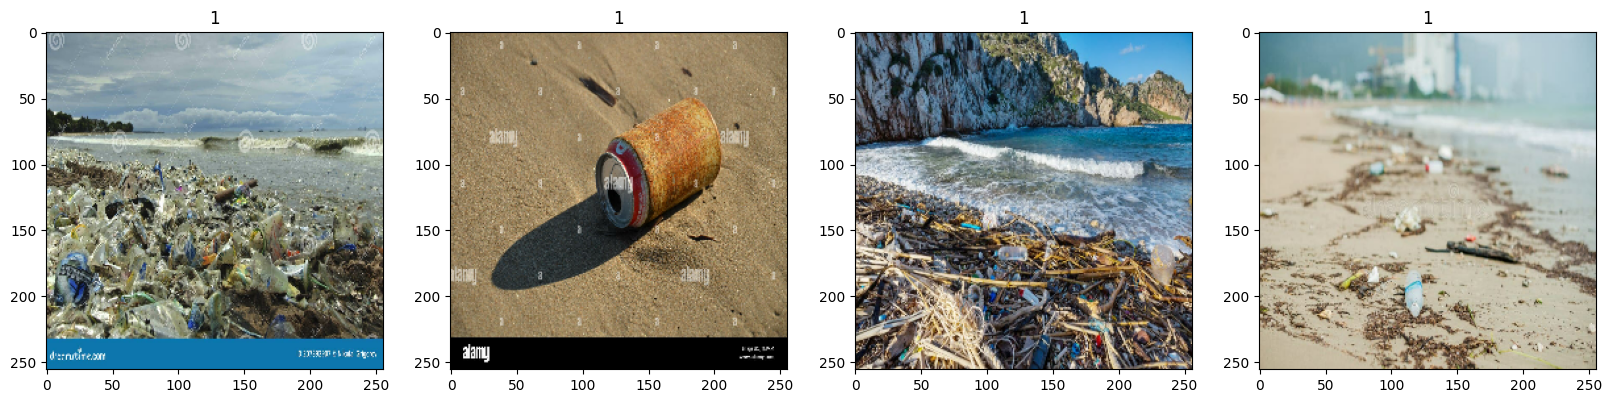

In [50]:
#waste - 1
# not waste - 0
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])
    
    

In [51]:
scaled = batch[0]/255.0

In [52]:
scaled.max()

np.float32(1.0)

**Preprocess the Data**

In [53]:
#Scale the data to range 0 to 1
data = data.map(lambda x,y: (x/255.0, y))

In [57]:
batch = data.as_numpy_iterator().next()
batch

(array([[[[0.51298255, 0.47138864, 0.35273054],
          [0.7062883 , 0.5859375 , 0.40640703],
          [0.38492647, 0.2518459 , 0.08427543],
          ...,
          [0.7848039 , 0.7848039 , 0.74558824],
          [0.78431374, 0.78431374, 0.74509805],
          [0.78431374, 0.78431374, 0.74509805]],
 
         [[0.37995175, 0.2933134 , 0.12575062],
          [0.5673598 , 0.41254595, 0.27052313],
          [0.5604703 , 0.44175476, 0.30262715],
          ...,
          [0.7848039 , 0.7848039 , 0.74558824],
          [0.78431374, 0.78431374, 0.74509805],
          [0.78431374, 0.78431374, 0.74509805]],
 
         [[0.41090304, 0.28701362, 0.11268383],
          [0.43722427, 0.2943934 , 0.15321691],
          [0.5644263 , 0.47894838, 0.30839077],
          ...,
          [0.78431374, 0.78431374, 0.74509805],
          [0.78431374, 0.78431374, 0.74509805],
          [0.78431374, 0.78431374, 0.74509805]],
 
         ...,
 
         [[0.05098039, 0.4627451 , 0.6784314 ],
          [0.05098

In [58]:
batch[0].max()

np.float32(1.0)

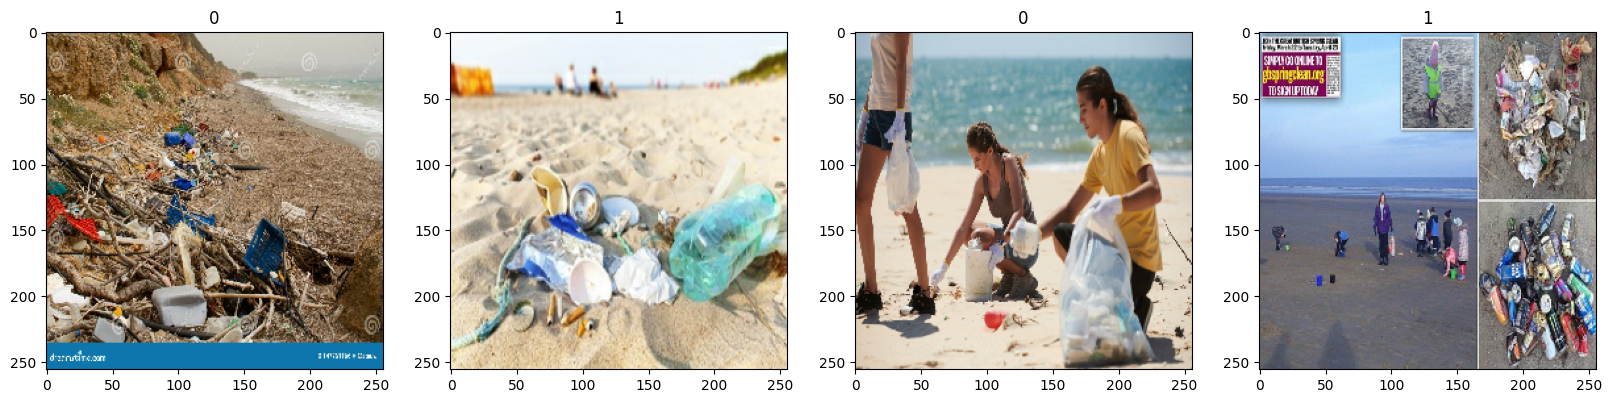

In [59]:
fig,ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])

**Split Data**

In [61]:
len(data)

7

In [68]:
train_size = int(len(data) * 0.7)
val_size = int(len(data) * 0.2)+1
test_size = int(len(data) * 0.1)+1

In [71]:
#Splitting the data
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size + val_size).take(test_size)

**Deep Model**

**Deep learning Model**

In [72]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout


In [73]:
model = Sequential()

In [74]:
model.add(Conv2D(16, (3,3),1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3),1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3),1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

e:\Marine_Debris\env\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [75]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])    

In [76]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 14400)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     3,686,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,696,625 (14.10 MB)

 Trainable params: 3,696,625 (14.10 MB)

 Non-trainable params: 0 (0.00 B)

**Training**

In [79]:
logdir='logs'

In [80]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [81]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 470ms/step - accuracy: 0.5391 - loss: 2.2933 - val_accuracy: 0.4531 - val_loss: 0.7354
Epoch 2/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 495ms/step - accuracy: 0.4922 - loss: 0.7025 - val_accuracy: 0.4688 - val_loss: 0.6967
Epoch 3/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 415ms/step - accuracy: 0.5312 - loss: 0.6934 - val_accuracy: 0.5625 - val_loss: 0.6850
Epoch 4/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 449ms/step - accuracy: 0.5938 - loss: 0.6784 - val_accuracy: 0.6562 - val_loss: 0.6599
Epoch 5/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 438ms/step - accuracy: 0.6562 - loss: 0.6667 - val_accuracy: 0.5000 - val_loss: 0.6689
Epoch 6/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 438ms/step - accuracy: 0.5938 - loss: 0.6431 - val_accuracy: 0.6875 - val_loss: 0.6103
Epoch 7/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 461ms/step - accuracy: 0.6641 - loss: 0.6412 - val_accuracy: 0.6250 - val_loss: 0.6222
Epoch 8/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 443ms/step - accuracy: 0.6953 - loss: 0.6261 - val_accuracy: 0.6250 - val_loss:

In [92]:
hist.history

{'accuracy': [0.5390625,
  0.4921875,
  0.53125,
  0.59375,
  0.65625,
  0.59375,
  0.6640625,
  0.6953125,
  0.796875,
  0.7734375,
  0.671875,
  0.859375,
  0.8359375,
  0.8125,
  0.75,
  0.8515625,
  0.859375,
  0.8984375,
  0.890625,
  0.90625],
 'loss': [2.2932631969451904,
  0.702486515045166,
  0.6934384107589722,
  0.6784079074859619,
  0.6666690111160278,
  0.6431134939193726,
  0.6412029266357422,
  0.6261271834373474,
  0.5687242746353149,
  0.5167136788368225,
  0.6268858313560486,
  0.5275537967681885,
  0.5256612300872803,
  0.4702502489089966,
  0.4957568049430847,
  0.41449347138404846,
  0.3543952703475952,
  0.29770317673683167,
  0.30044132471084595,
  0.24577385187149048],
 'val_accuracy': [0.453125,
  0.46875,
  0.5625,
  0.65625,
  0.5,
  0.6875,
  0.625,
  0.625,
  0.734375,
  0.5,
  0.765625,
  0.84375,
  0.9375,
  0.578125,
  0.890625,
  0.828125,
  0.890625,
  0.859375,
  0.84375,
  0.984375],
 'val_loss': [0.7353622913360596,
  0.6966690421104431,
  0.6850017

In [94]:
hist.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

**Model performance**

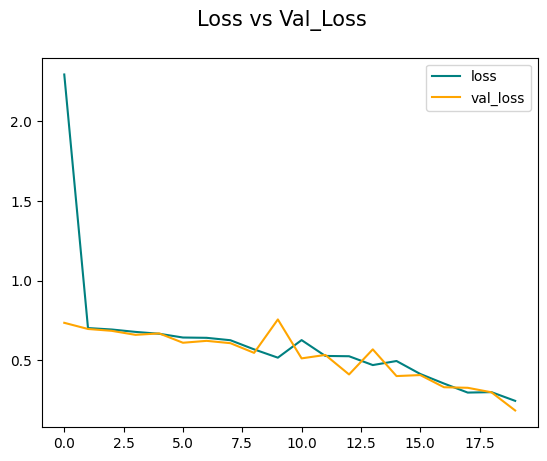

In [87]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')  
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
plt.suptitle('Loss vs Val_Loss',fontsize=15)
plt.legend(loc = 'upper right')
plt.show()

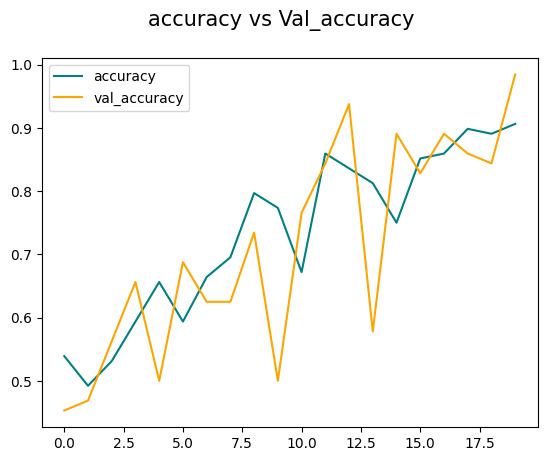

In [95]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')  
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
plt.suptitle('accuracy vs Val_accuracy',fontsize=15)
plt.legend(loc = 'upper left')
plt.show()